<a href="https://colab.research.google.com/github/pradeep-84690/Skin_Cancer-Classification/blob/main/PROJECT_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import collections
import os
from glob import glob
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

importing dataset

In [2]:
df = pd.read_csv('/content/drive/MyDrive/HAM10000_images_part_1/Ham10000_new.csv')
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk
4,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest


getting Image's Path from google drive

In [3]:
base_skin_dir = '/content/drive/MyDrive/HAM10000_images_part_1'
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                   for x in glob(os.path.join(base_skin_dir, '*.jpg'))}

lesion_dict = {
                  'nv': 'Melanocytic nevi',
                  'mel': 'Melanoma',
                  'bkl': 'Benign keratosis-like lesions ',
                  'bcc': 'Basal cell carcinoma',
                  'akiec': 'Actinic keratoses',
                  'vasc': 'Vascular lesions',
                  'df': 'Dermatofibroma'
              }

In [4]:
len(imageid_path_dict)

4854

adding image path, cell_type and encoding the cell type

In [5]:
df = pd.read_csv('/content/drive/MyDrive/HAM10000_images_part_1/Ham10000_new.csv')

df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_dict.get)
df['cell_type_encoded'] = pd.Categorical(df['cell_type']).codes
df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_encoded
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,/content/drive/MyDrive/HAM10000_images_part_1/...,Melanocytic nevi,4
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,/content/drive/MyDrive/HAM10000_images_part_1/...,Melanocytic nevi,4
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,/content/drive/MyDrive/HAM10000_images_part_1/...,Melanocytic nevi,4
3,HAM_0000484,ISIC_0024309,nv,follow_up,40.0,male,trunk,/content/drive/MyDrive/HAM10000_images_part_1/...,Melanocytic nevi,4
4,HAM_0003350,ISIC_0024310,mel,histo,60.0,male,chest,/content/drive/MyDrive/HAM10000_images_part_1/...,Melanoma,5


cheking for null values

In [6]:
df.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,3
sex,0
localization,0
path,152
cell_type,0
cell_type_encoded,0


filling null values of age using mean

In [7]:
df['age'] = df['age'].fillna((df['age'].mean()))
df.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
path,152
cell_type,0
cell_type_encoded,0


removing records with null values in path attribute

In [8]:
df.dropna(subset=['path'],axis=0,inplace=True)
df.isna().sum()

,0
lesion_id,0
image_id,0
dx,0
dx_type,0
age,0
sex,0
localization,0
path,0
cell_type,0
cell_type_encoded,0


displaying original image of 450 x 600 pixel values

<Figure size 500x500 with 0 Axes>

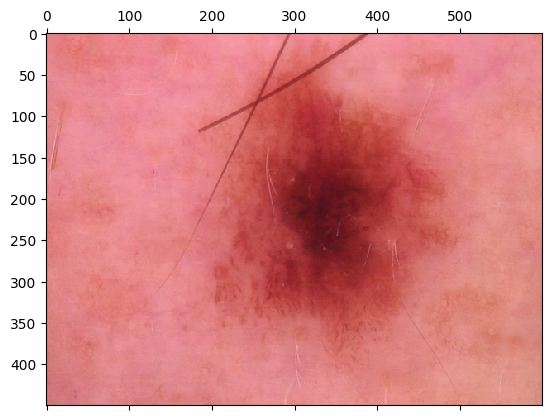

In [9]:
plt.figure(figsize=(5, 5))
img = cv2.imread(df['path'][0],cv2.IMREAD_COLOR_RGB)
plt.matshow(img)
plt.show()

extracting imagies from google drive using it's path and resized it to 64 x 64, and added all into 'Image' attribute

In [10]:
df['image'] = df['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))
df.head(3)

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_encoded,image
0,HAM_0000550,ISIC_0024306,nv,follow_up,45.0,male,trunk,/content/drive/MyDrive/HAM10000_images_part_1/...,Melanocytic nevi,4,"[[[229, 131, 134], [230, 126, 133], [230, 125,..."
1,HAM_0003577,ISIC_0024307,nv,follow_up,50.0,male,lower extremity,/content/drive/MyDrive/HAM10000_images_part_1/...,Melanocytic nevi,4,"[[[216, 120, 133], [218, 124, 139], [218, 124,..."
2,HAM_0001477,ISIC_0024308,nv,follow_up,55.0,female,trunk,/content/drive/MyDrive/HAM10000_images_part_1/...,Melanocytic nevi,4,"[[[246, 173, 179], [246, 170, 176], [246, 173,..."


sample of resized image

<Figure size 500x500 with 0 Axes>

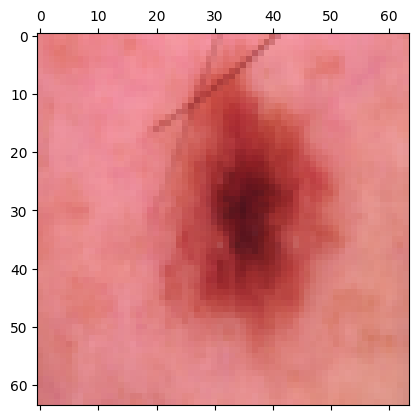

In [11]:
plt.figure(figsize=(5, 5))
plt.matshow(df['image'][0])
plt.show()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4848 entries, 0 to 4999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   lesion_id          4848 non-null   object 
 1   image_id           4848 non-null   object 
 2   dx                 4848 non-null   object 
 3   dx_type            4848 non-null   object 
 4   age                4848 non-null   float64
 5   sex                4848 non-null   object 
 6   localization       4848 non-null   object 
 7   path               4848 non-null   object 
 8   cell_type          4848 non-null   object 
 9   cell_type_encoded  4848 non-null   int8   
 10  image              4848 non-null   object 
dtypes: float64(1), int8(1), object(9)
memory usage: 550.4+ KB


distribution of each cancer type in database

In [13]:
x = df[['cell_type_encoded','cell_type']].value_counts()
print(x)
print('total records: ',len(df))

cell_type_encoded  cell_type                     
4                  Melanocytic nevi                  3322
2                  Benign keratosis-like lesions      551
5                  Melanoma                           432
1                  Basal cell carcinoma               264
0                  Actinic keratoses                  178
6                  Vascular lesions                    55
3                  Dermatofibroma                      46
Name: count, dtype: int64
total records:  4848


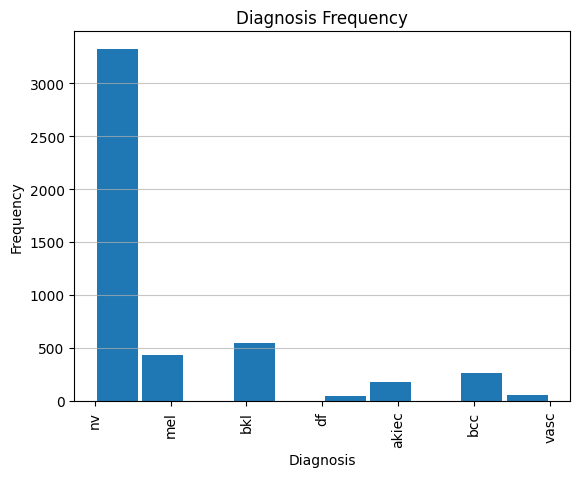

In [14]:
plt.hist(df['dx'],rwidth=0.9)
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='-', alpha=0.7)
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.title('Diagnosis Frequency')
plt.show()

In [15]:
df['image'].map(lambda x: x.shape).value_counts()

,count
image,
"(64, 64, 3)",4848


selecting feature and target variables

In [16]:
features = df['image']
target = df['cell_type_encoded']

In [17]:
features_array = np.asarray(features.tolist())

In [18]:
# feature_norm = features_array/255
print(features_array.shape)
print(target.shape)

(4848, 64, 64, 3)
(4848,)


In [19]:
class_counts = collections.Counter(target)
print("Class distribution:", class_counts)

Class distribution: Counter({4: 3322, 2: 551, 5: 432, 1: 264, 0: 178, 6: 55, 3: 46})


In [20]:
max_samples = max(class_counts.values())
print("Maximum samples per class:", max_samples)

Maximum samples per class: 3322


using image generator, to generate synthetic imagies of minor classes

In [21]:
augmenter = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [22]:
X_augmented = []
y_augmented = []

for class_label, count in class_counts.items():
    if count < max_samples:
        # Get all samples of this class
        X_class = features_array[target == class_label]
        num_to_generate = max_samples - count
        X_class = np.asarray(X_class.tolist())
        print(X_class.shape)

        # Create a generator
        gen = augmenter.flow(X_class, batch_size=1)

        for _ in range(num_to_generate):
            augmented_img = next(gen)[0]
            X_augmented.append(augmented_img)
            y_augmented.append(class_label)

(432, 64, 64, 3)
(551, 64, 64, 3)
(46, 64, 64, 3)
(178, 64, 64, 3)
(264, 64, 64, 3)
(55, 64, 64, 3)


In [23]:
class_4 = df[df['cell_type_encoded']==4]
class_4_augmented = np.asarray(class_4['image'].tolist())
class_4_target = class_4['cell_type_encoded']
X_augmented = np.concatenate((class_4_augmented,X_augmented),axis=0)
y_augmented = np.concatenate((class_4_target,y_augmented),axis=0)
# print(class_4_augmented.shape)
# print(class_4_target.shape)
print(np.asarray(X_augmented).shape,',',np.asarray(y_augmented).shape)

(21728, 64, 64, 3) , (21728,)


distribution of each class after augmentation process

In [24]:
for i in range(0,7):
  print(f'records for class {i} : ',list((y_augmented)).count(i))
print('total records: ',len(X_augmented))

records for class 0 :  3144
records for class 1 :  3058
records for class 2 :  2771
records for class 3 :  3276
records for class 4 :  3322
records for class 5 :  2890
records for class 6 :  3267
total records:  21728


data normalization

In [25]:
X_augmented = np.asarray(X_augmented)
X_augmented_norm = X_augmented/255
y_augmented = to_categorical(np.asarray(y_augmented), num_classes=7)


In [26]:
print(X_augmented_norm.shape)
print(y_augmented.shape)

(21728, 64, 64, 3)
(21728, 7)


In [27]:
x_balanced = X_augmented_norm
y_balanced = y_augmented

dividing datset into training, testing and validation sets

In [28]:
x_train, x_test, y_train, y_test = train_test_split(x_balanced, y_balanced, test_size = 0.2, random_state =42)
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state =42)

size of training, testing, and validation dataset

In [29]:
print(x_train.shape)
print(x_test.shape)
print(x_validate.shape)

(15643, 64, 64, 3)
(4346, 64, 64, 3)
(1739, 64, 64, 3)


Model creation  ad excecution

In [30]:
input_shape = (64, 64, 3)
num_classes = 7

#Setting up CNN Classifier Layer-set 1 (4 Layers):
classifier = Sequential()
classifier.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=input_shape))
classifier.add(Conv2D(32,kernel_size=(3, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size = (2, 2)))
classifier.add(Dropout(0.20))

#Setting up CNN Classifier Layer-set 2 (4 Layers):
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2, 2)))
classifier.add(Dropout(0.20))

#Setting up CNN Classifier Layer-set 3 (4 Layers):
classifier.add(Flatten())
classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.5))
classifier.add(Dense(num_classes, activation='softmax'))

#Displaying Summary of all 12 Neural Layers created:
classifier.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 26, 26, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,384,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,451,047 (5.54 MB)

 Trainable params: 1,451,047 (5.54 MB)

 Non-trainable params: 0 (0.00 B)

In [31]:
classifier.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

In [32]:
epochs = 100
batch_size = 128
# steps_per_epoch = len(x_train) // batch_size

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=3, min_lr=0.0010)

#Fitting data to model and saving it to variable 'history':
history = classifier.fit(x_train,y_train,batch_size=batch_size,
                         callbacks = [reduce_lr,early_stop],
                         epochs = epochs, validation_data = (x_validate,y_validate),
                         )


Epoch 1/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.2357 - loss: 1.8363 - val_accuracy: 0.4048 - val_loss: 1.5236 - learning_rate: 0.0010
Epoch 2/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.4310 - loss: 1.4304 - val_accuracy: 0.5221 - val_loss: 1.2478 - learning_rate: 0.0010
Epoch 3/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.4945 - loss: 1.3033 - val_accuracy: 0.5756 - val_loss: 1.1444 - learning_rate: 0.0010
Epoch 4/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5285 - loss: 1.1910 - val_accuracy: 0.5848 - val_loss: 1.0966 - learning_rate: 0.0010
Epoch 5/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5547 - loss: 1.1478 - val_accuracy: 0.6084 - val_loss: 1.0613 - learning_rate: 0.0010
Epoch 6/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.5679 - loss: 1.1073 - val_accuracy: 0.6095 - val_loss: 1.0017 - learning_rate: 0.0010
Epoch 7/100
123/123 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - accuracy: 0.5826 - 

Model's testing and validation accuary

In [33]:
loss, accuracy = classifier.evaluate(x_test, y_test)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate)
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))

136/136 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7979 - loss: 0.5738
55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.8133 - loss: 0.5403
Test: accuracy = 0.800046  ;  loss = 0.564299
Validation: accuracy = 0.811961  ;  loss_v = 0.538171


<Axes: xlabel='cell_type'>

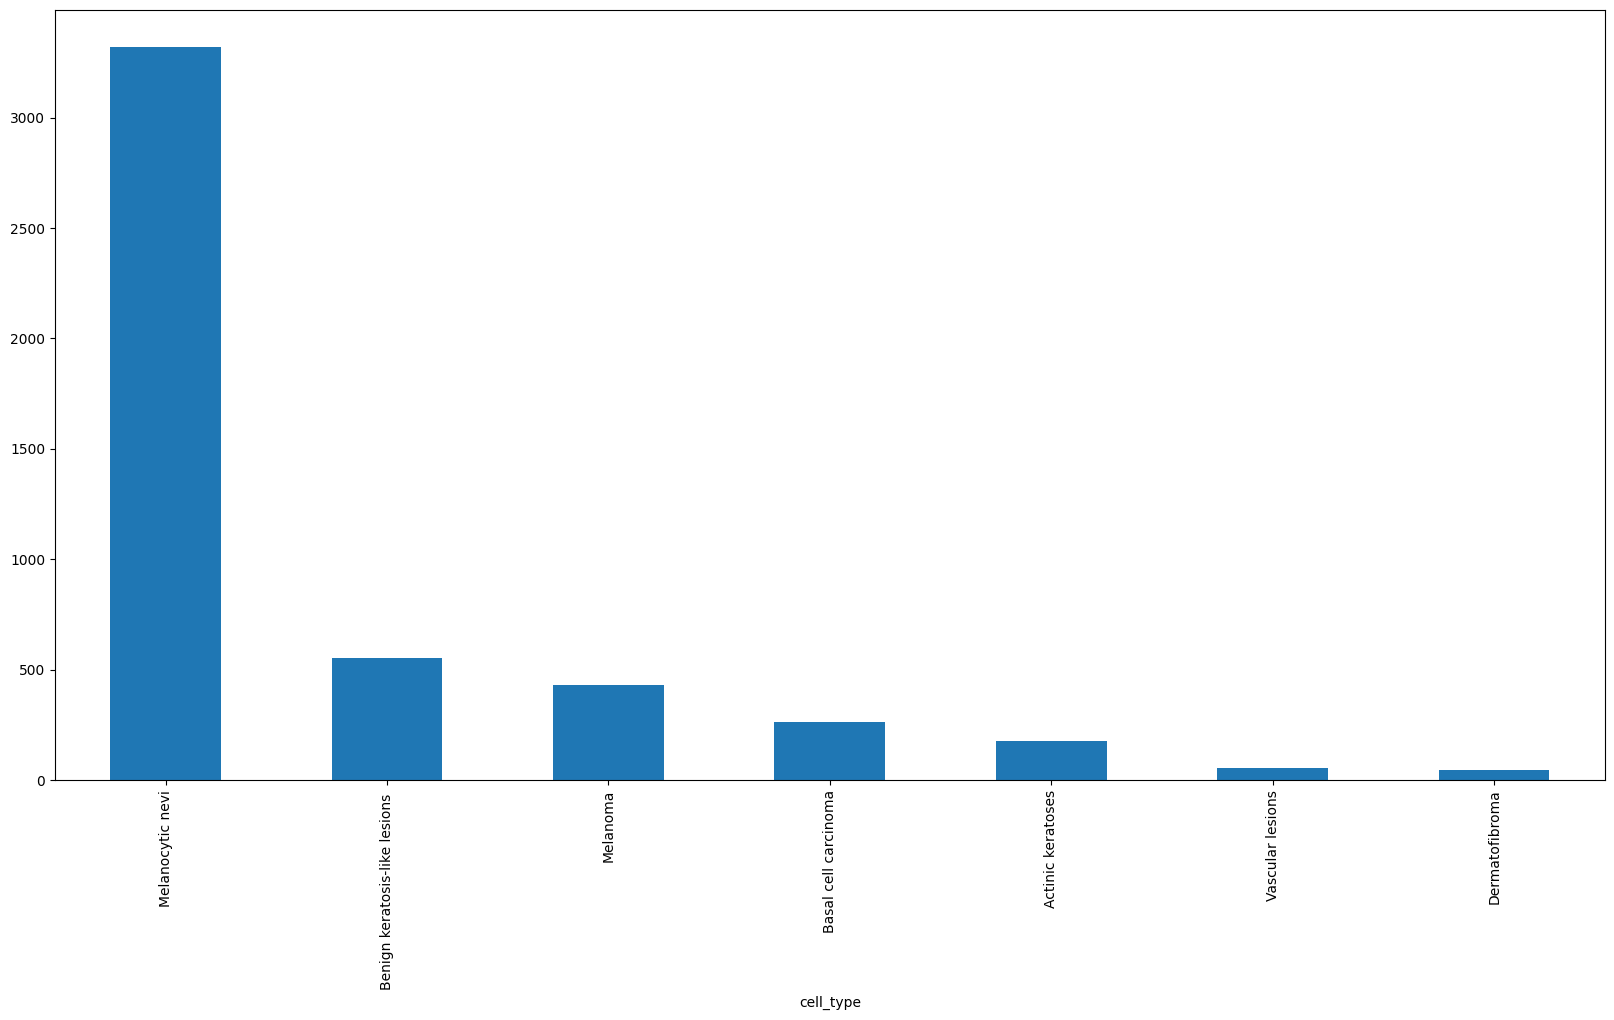

In [34]:
fig, ax1 = plt.subplots(1, 1, figsize= (20, 10))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

<Axes: xlabel='dx_type'>

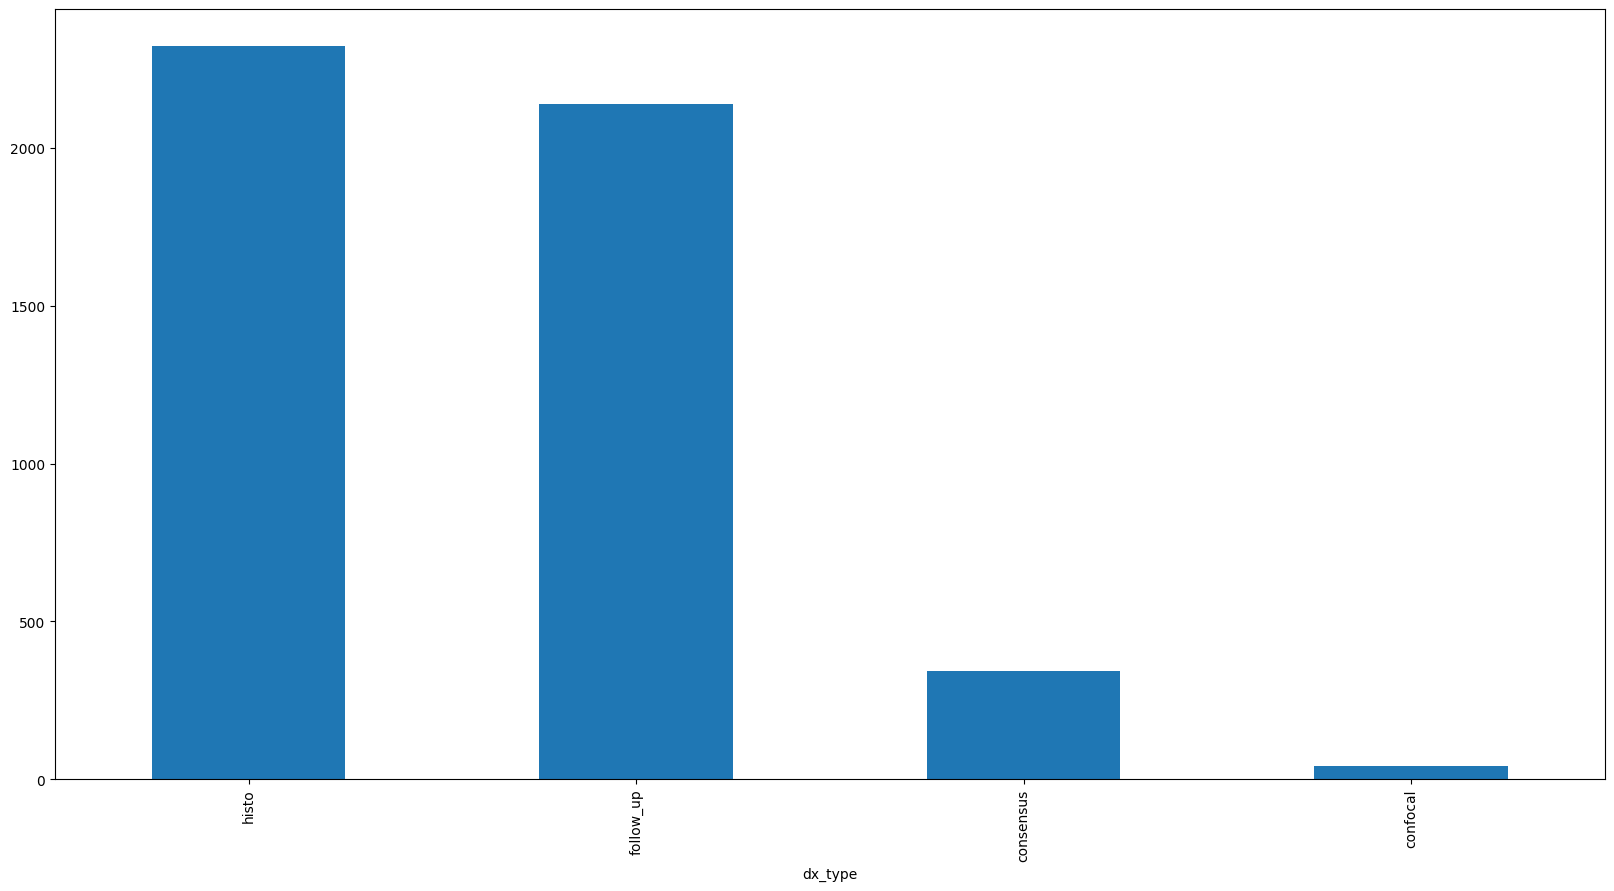

In [35]:
fig, ax1 = plt.subplots(1, 1, figsize= (20, 10))
df['dx_type'].value_counts().plot(kind='bar')

<Axes: xlabel='localization'>

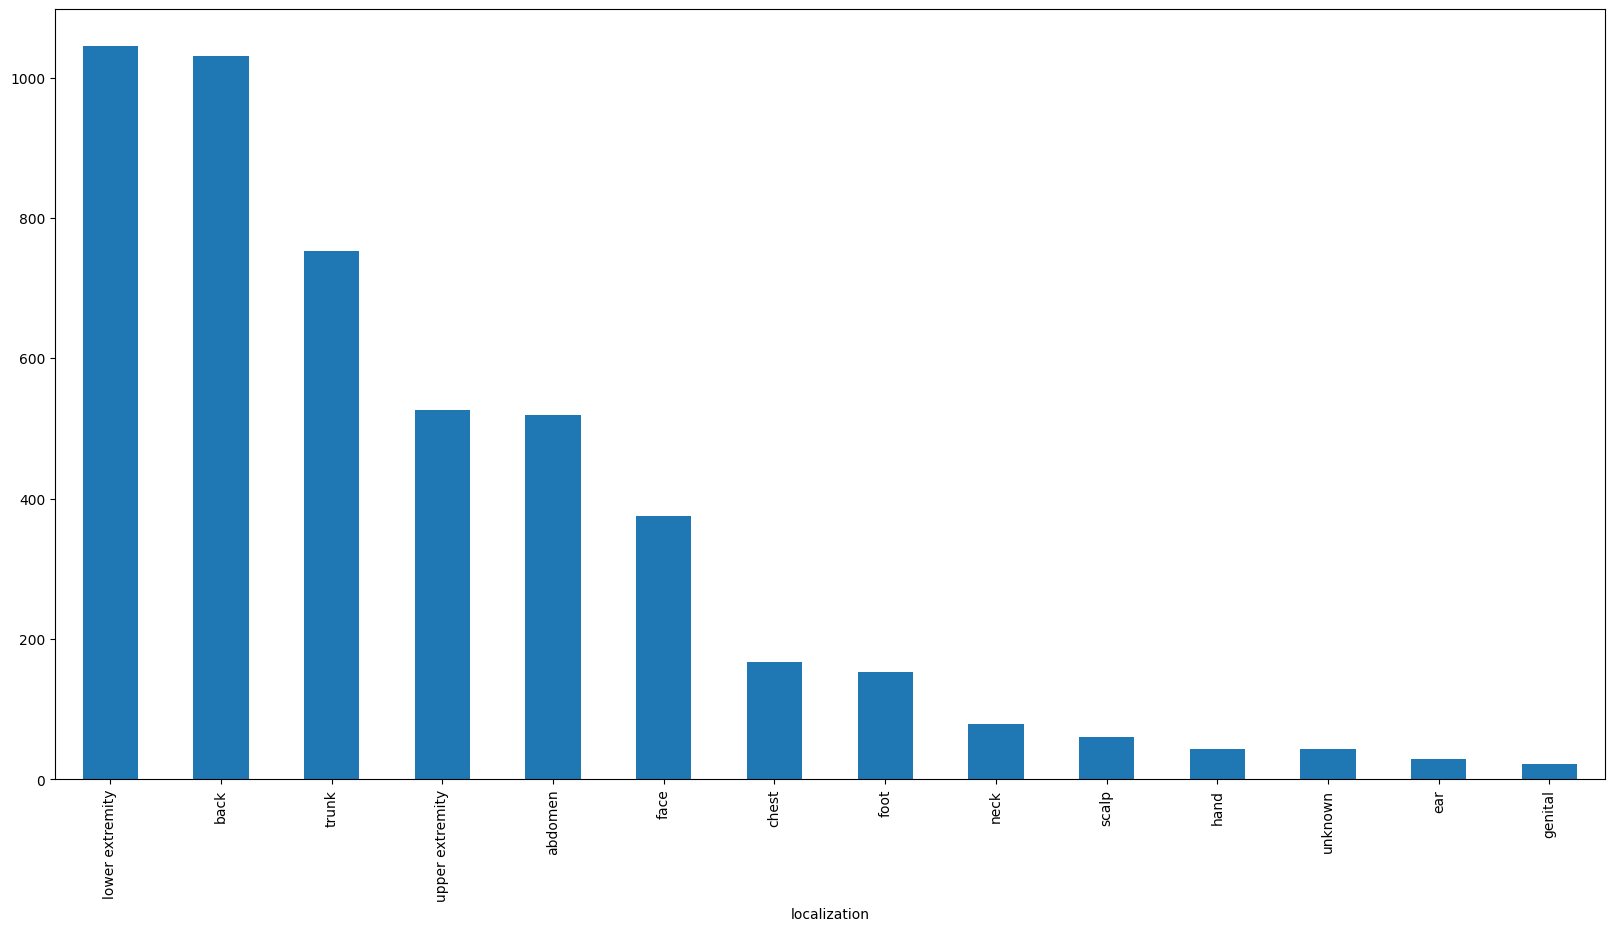

In [36]:
fig, ax1 = plt.subplots(1, 1, figsize= (20, 10))
df['localization'].value_counts().plot(kind='bar')

<Axes: >

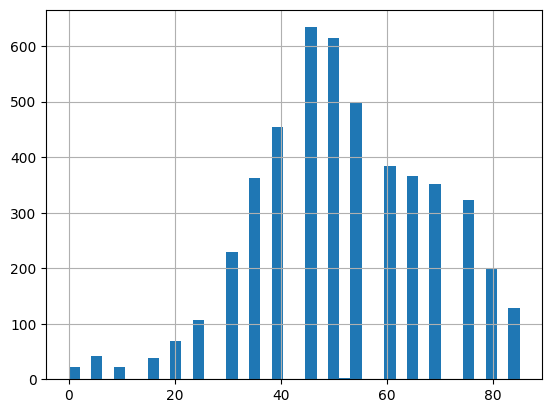

In [37]:
df['age'].hist(bins=40)

<Axes: >

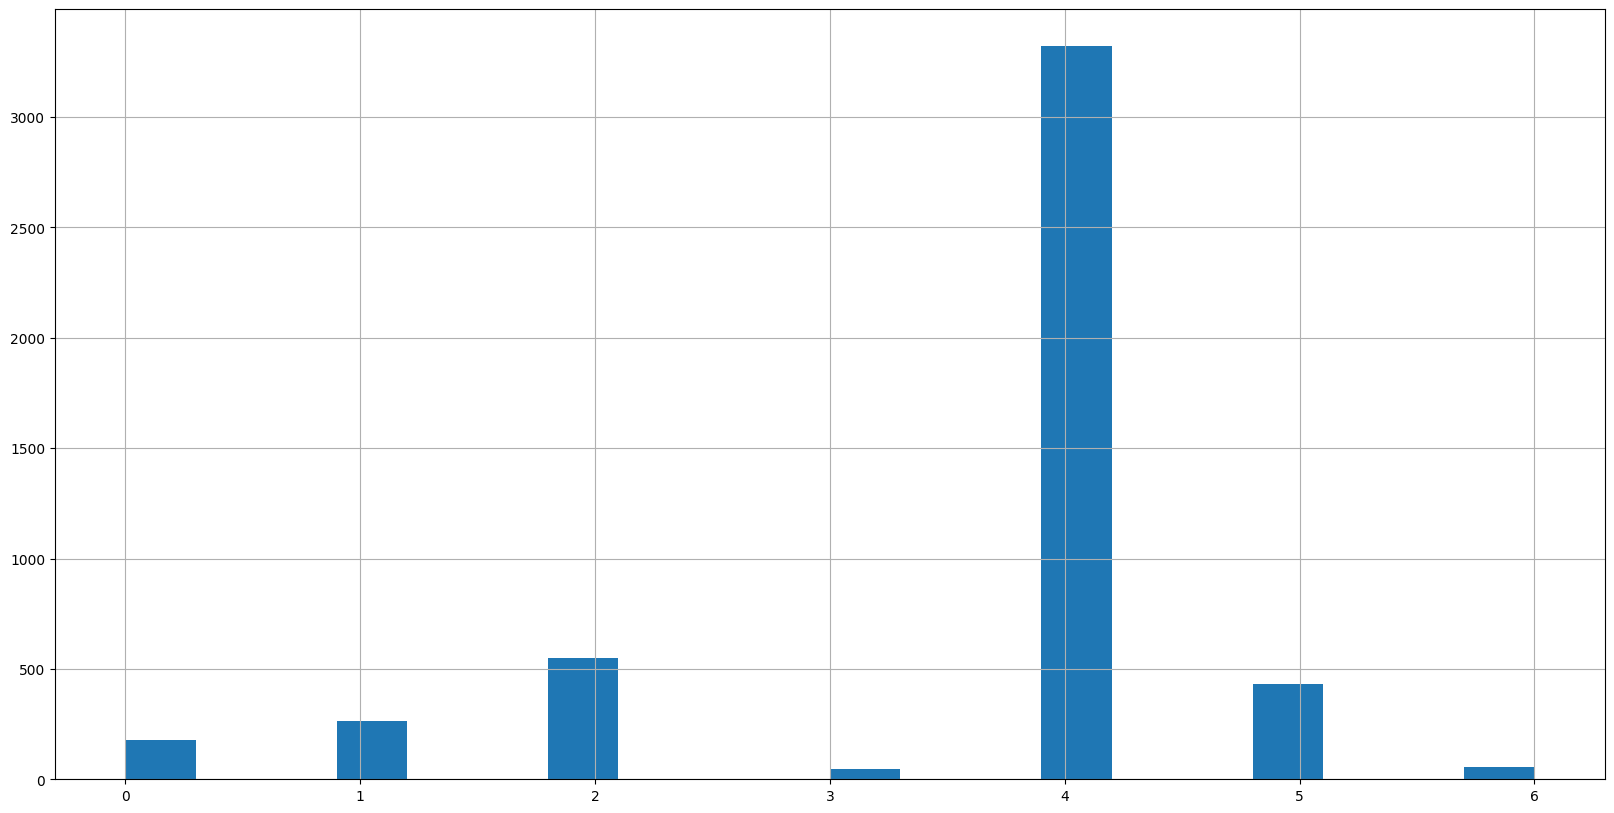

In [38]:
fig, ax1 = plt.subplots(1, 1, figsize= (20, 10))
df['cell_type_encoded'].hist(bins=20)

In [39]:
print(x_train.shape)
print(x_test.shape)

(15643, 64, 64, 3)
(4346, 64, 64, 3)


Model's actual predections vs original results

In [40]:
y_pred = classifier.predict(x_test[1:10])
y_pred = np.argmax(y_pred, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 875ms/step


In [41]:
def show_cancer_type(arr):
    skin_cancer_types = ['Actinic keratoses', 'Basal cell carcinoma', 'Benign keratosis-like lesions',
                         'Dermatofibroma', 'Melanocytic nevi', 'Melanoma', 'Vascular lesions']
    for i in range(len(arr)):
        print(skin_cancer_types[arr[i]])

show_cancer_type(y_pred)

Melanocytic nevi
Dermatofibroma
Actinic keratoses
Melanocytic nevi
Dermatofibroma
Actinic keratoses
Basal cell carcinoma
Basal cell carcinoma
Melanocytic nevi


In [42]:
indices_with_greatest_value = np.argmax(y_test[1:10], axis=1)
show_cancer_type(indices_with_greatest_value)

Melanocytic nevi
Dermatofibroma
Benign keratosis-like lesions
Melanoma
Dermatofibroma
Actinic keratoses
Basal cell carcinoma
Benign keratosis-like lesions
Melanocytic nevi


Model's classification report

In [43]:
y_true = np.argmax(y_test,axis=1)  # True labels from your test set
y_pred = classifier.predict(x_test)  # Predictions from your model
y_pred = np.argmax(y_pred,axis=1)  # Convert predictions to class labels if needed

# Generate the classification report
report = classification_report(y_true, y_pred)

# Print the report
print(report)

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
              precision    recall  f1-score   support

           0       0.69      0.78      0.73       620
           1       0.77      0.70      0.73       616
           2       0.69      0.58      0.63       566
           3       0.89      0.97      0.93       644
           4       0.80      0.80      0.80       628
           5       0.73      0.73      0.73       597
           6       0.99      0.99      0.99       675

    accuracy                           0.80      4346
   macro avg       0.79      0.79      0.79      4346
weighted avg       0.80      0.80      0.80      4346



Visualization of Epochs vs Accuracy and Epochs vs Loss

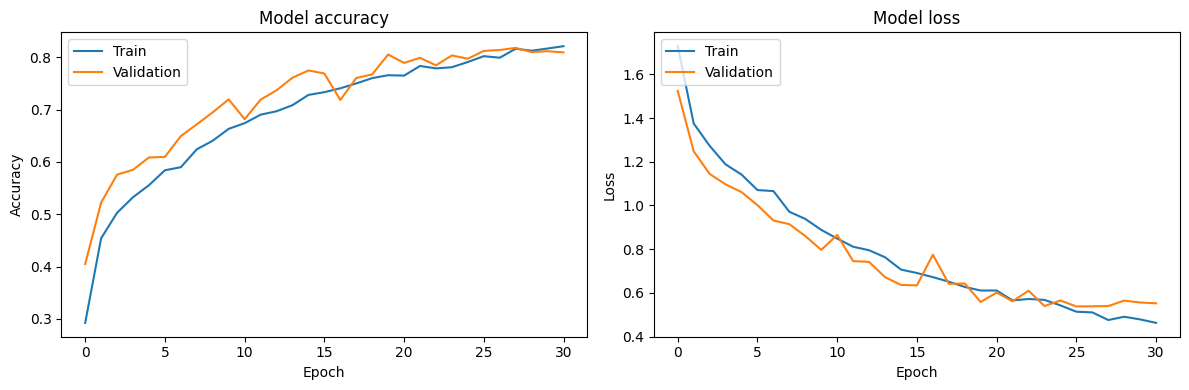

In [44]:
plt.figure(figsize=(12, 4))  # Adjust figure size if needed

plt.subplot(1, 2, 1)  # Create a subplot for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)  # Create a subplot for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()  # Adjust layout for better spacing
plt.show()

Confusion matrix of features

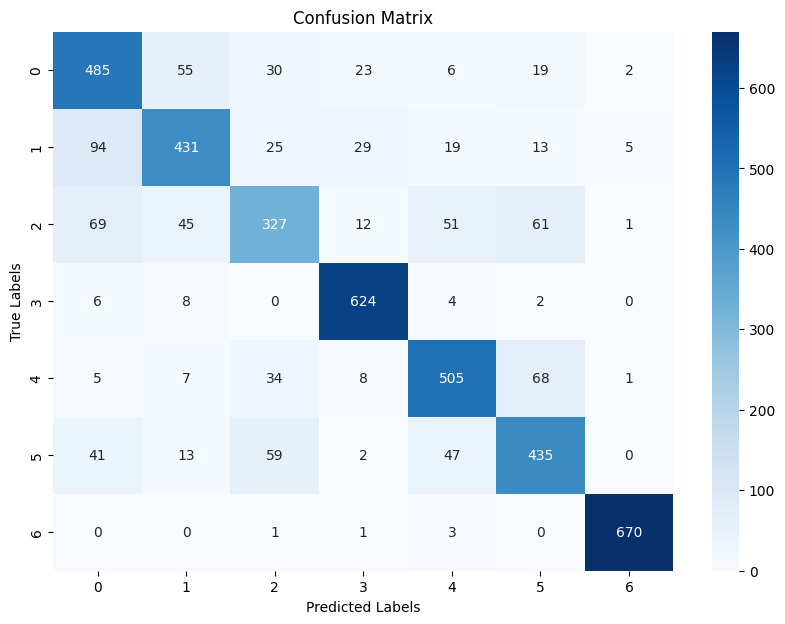

In [45]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()